# Chapter 1: Foundations

## Introduction

An important task in probabilistic modelling is inference of the posterior distribution $p(Z|X)$ of $Z$, the model's latent variables, given $X$, the observed data. It is oftentimes desirable to obtain estimates for these latent variables (which in the Bayesian case include a model's parameters) and uncertainty measures around such estimates.  

Consider a set of $N$ independent, identically distributed observations. Let $X=\{x_1, x_2, \cdots, x_N\}$ and, correspondingly, $Z=\{z_1, z_2, \cdots, z_N\}$. Typically, a probabilistic model begins by specifying a joint distribution $p(X,Z)$ or, equivalently, by characterising $p(X|Z)$ (the likelihood) and $P(Z)$ (prior over the latent variables).

If the distributions are nice enough, we can compute both $p(Z|X)$ (posterior) and $P(X)$ (evidence):
$$
p(Z|X) = \frac{p(X|Z)p(Z)}{P(X)} = \frac{p(X|Z)p(Z)}{\int p(X|Z)p(Z) dZ}
$$
Unfortunately, the integral in the denominator is often intractable; a closed analytical form for it might not exist and numerical approximations do not scale well with increasing dimensionality in the latent variables.


## Solutions

- Monte Carlo
- Approximate Posterior Inference

## Kullback–Leibler divergence

It is a measure of how one probability distribution $P$ is different from a second distribution $Q$. Relevantly, the corresponding [Wikipedia article](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) states "A simple interpretation of the KL divergence of $P$ from $Q$ is the expected excess surprise from using $Q$ as a model when the actual distribution is $P$"

$$
KL(p||q) =  \int p(x) \ln \frac{p(x)}{q(x)} dx
$$

Importantly, we do call it a divergence instead of distance; the KL divergence is not symmetric! Hence, it is not a distance. Nevertheless, it has the following properties:

- $KL(q||p) = 0$ if and only if $p(x)=q(x)$ almost everywhere and,
- $KL(q||p) \geq 0$.

Practically, when the probability distributions $p$ and $q$ have disjoint supports, that is, when one of the distributions has positive density or probability mass but the other does not, the KL divergence can become undefined or infinite. This is an important consideration when comparing distributions with non-overlapping supports.



Suppose now that both $q$ and $p$ are the pdfs of normal distributions of dimension $d$ with means $\mu_q$ and $\mu_p$, and variance $\Sigma_q$ and $\Sigma_p$, respectively. Th KL-divergence between them can be shown to be: 

$$
KL(p||q) = \frac{1}{2}(\log (\frac{|\Sigma_q|}{|\Sigma_p|}) - d + (\mu_p - \mu_q)^T \Sigma_q^{-1}(\mu_p - \mu_q) + tr(\Sigma_q^{-1}\Sigma_p))
$$

By inspection, if $\mu_1 = \mu_2$ and $\Sigma_1=\Sigma_2$, then $KL(p||q)=0$, the minimum. Also notice that it is not symmetric, namely, $KL(q||p)\neq KL(p||q)$. Our intuition checks out. To drive the point home and get our feet wet on this easy example in which we will minimize the KL divergence between two normals by varying the parameters of one of them.

A natural question to raise when considering the assymetry of the KL divergence is which option is best for your use case; what are their corresponding strength and weaknesses and under what circumstances, if any, one is better suited than the other for fitting a distribution $q$ to $p$. We will analyze their behaviour next.

In [1]:
import torch
from torch.optim import SGD, Adam
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import log, det, inverse, trace, matmul, logdet

#### Define loss

In [2]:
def multivariateNormal_KL(params_q: tuple, params_p: tuple) -> float:
    """
    Computes the KL-divergence KL(q||p) of two multivariate normal distributions. 
    Inputs:
        - params_q (Tuple): (mean_q, cov_q)
        - params_p (Tuple): (mean_p, cov_p)
    Output:
        - KL-divergence between q and p.

    Comments: 
        This example is meant to illustrate the computation of the KL divergence between two normals. As such,
        it does not concern itself too much with numerical stability. Specifically, we do not make use of torch.logdet
        or other tools aimed at improving convergence for the sake of keeping the clarity of our exposition.
    """

    mu_q, sigma_q = params_q[0], params_q[1]
    mu_p, sigma_p = params_p[0], params_p[1]

    # Intermediate variables
    d = mu_q.size(0)
    means_diff = mu_q - mu_p

    #KL_div = 0.5 * (log(det(sigma_p)/det(sigma_q)) - d + matmul(matmul(means_diff, inverse(sigma_p)), means_diff) + trace(matmul(inverse(sigma_p), sigma_q)))
    KL_div = 0.5 * (logdet(sigma_p) - logdet(sigma_q) - d + matmul(matmul(means_diff, inverse(sigma_p)), means_diff) + trace(matmul(inverse(sigma_p), sigma_q)))
    return KL_div



### Instantiate parameters

In [3]:
d = 3

# A is used to generate positive definite matrix
A =  torch.rand(d, d)
positive_definite_matrix = torch.mm(A, A.t())

sigma_q = positive_definite_matrix.requires_grad_(True)
mu_q = MultivariateNormal(loc=torch.zeros(d) + 10, covariance_matrix=torch.eye(d)).sample().requires_grad_(True)

sigma_p = torch.eye(d, requires_grad=False)
mu_p = torch.zeros(d, requires_grad=False)

In [4]:
num_epochs = 200
q_params = (mu_q, sigma_q)
p_params = (mu_p, sigma_p)

#optimizer = Adam(q_params, lr=0.01)
optimizer = SGD(q_params, lr=0.1)

kl_divs = list()
epsilon = 1e-3

for epoch in range(num_epochs):
    optimizer.zero_grad()
    kl_div =  multivariateNormal_KL(q_params, p_params)
    kl_div.backward()
    optimizer.step()
    #print(det(sigma_q))
    kl_divs.append(kl_div.item())

    if epoch > 1 and abs(kl_divs[-2] - kl_divs[-1]) < epsilon:
        print("Algorithm converged.")
        print("mu_q is", mu_q)
        print("Sigma_q is", sigma_q)
        break


Algorithm converged.
mu_q is tensor([0.0002, 0.0001, 0.0002], requires_grad=True)
Sigma_q is tensor([[1.0391, 0.0472, 0.0735],
        [0.0472, 1.0536, 0.0857],
        [0.0736, 0.0857, 1.1321]], requires_grad=True)


### The forward KL


#### Description
Letting $Q = Q_{\theta}$ be our approximating distribution, the forward KL has the 'ground truth', complex distribution $P$ as first argument to the KL divergence, that is, $KL(P||Q_{\theta})$. Importantly, the difference between the distributions is weighted by the values of $p(x)$:

$$
KL(P||Q) = E_{p}[\ln \frac{p(x)}{q_{\theta}(x)}] = \int p(x) \ln \frac{p(x)}{q_{\theta}(x)} dx.
$$

This highlights the fact that whenever $p(x)=0$ and $q(x)>0$, then the value of $\ln \frac{p(x)}{q_{\theta}(x)}$ will not bear much importance, even if it is very big[<sup>1</sup>](#fn1). Therefore, one might reasonably claim the $KL(P||Q)$ is already minimized with respect to $Q$ for the values outside the support of $P$. Put differently, the forward KL does not penalize distribution $Q$ for having positive mass outside of $P$'s support.

Now consider the values on $P$'s support, if $q(x) \to 0$ then $KL(P||Q) \to \infty$. Therefore, by minimizing the divergence, we are then forcing $q(x)>0$ whenever $p(x)>0$. This is why the forward KL is often described as **mass-covering** or **zero-avoiding**.


#### Objective
More formally, consider the problem of optimizing the forward KL objective with respect to $q_{\theta}$:

$$
\argmin_{\theta} D_{KL}(P||Q_{\theta}) = \argmin_{\theta} E_{p}[\ln \frac{p(x)}{q_{\theta}(x)}] \\ = \argmin_{\theta} E_{p}[-\ln q_{\theta}(x)] \\ = \argmax_{\theta} E_{p}[\ln q_{\theta}(x)]
$$



#### Evaluation

The expression above is identical to the maximum likelihood estimation objective, i.e., finding the parameters that maximize the likelihood (loglikelihood, equivalently) of $Q$ under the law of $P$. Since our data is usually i.i.d., the expression factorizes and simplifies to:

$$
\argmax_{\theta} E_{p}[\ln q_{\theta}(x)] \approx \argmax_{\theta} \frac{1}{n} \sum_{i=1}^{n} \ln q_{\theta}(x_i),
$$
by the Law of Large Numbers. Therefore, if we have independent samples from $P$ in the form of a dataset, or a procedure for sampling from $P$ at will, we can evaluate our expression and maximize it with respect to $q_{\theta}$. Otherwise, this is hard to compute, since $P$ is presumed to be the intractable, 'real-world' distribution, we tend to not be able to compute expectations; we are essentially back to the same problem as in the introduction of evaluating $p(x)$. 

### The reverse KL

Again, letting $Q = Q_{\theta}$ be our approximating distribution, the reverse KL has the 'real world' distribution $P$ as **second** argument to the KL divergence, that is,

$$
KL(Q_{\theta}||P) = E_{q_{\theta}}[\ln \frac{q_{\theta}(x)}{p(x)}] = \int q_{\theta}(x) \ln \frac{q_{\theta}(x)}{p(x)} dx.
$$

This will induce a behaviour called **zero-forcing**, when $p(x)=0$, then $q(x)=0$.

Do not give up on the reverse KL, though. It will come back banging.

### The $\alpha$ family of divergences

The forward and the reverse KL belong to a larger family of divergences called the $\alpha$-family of divergences. In general, $\alpha \in (-\infty,\infty)$, and the forward KL corresponds to taking the limit $\alpha \to 1$. Analogously, it can be proved that the reverse KL is obtained by taking the limit $\alpha \to -1$.

$$
D_{\alpha}(p||q) = \frac{4}{1 - \alpha^2}(1 - \int p(x)^{\frac{1+\alpha}{2}} q(x)^{\frac{1-\alpha}{2}}dx)
$$

When $\alpha \geq 1$, the divergence is **zero-avoiding**. Conversely, when $\alpha \leq 1$, the divergence is **zero-forcing**.

## Homework

Choose any one of the following [KL-Divergences](https://statproofbook.github.io/I/ToC#Probability%20Distributions), call the first distribution $q$ and the second $p$. Follow the proof and minimize the KL-divergence with respect to $q$'s parameters. They (approach?) the parameters of $p$.

## Dive into research

The KL divergence has a closed analytical form for various distributions like Bernoulli, binomial, the Gamma, e.g. exponential distributions, and the Dirichlet, e.g. beta, family. These equations assume that $p$ and $q$ have the same distribution, but a different set of parameters, which will determine the divergence between them; if the parameters are the same, the divergence is $0$. This raises two questions:

-   How does the divergence look when $p$ and $q$ have a different distributions?
-   Sometimes we do not know the distributions themselves, and only have a sample of independent, identically distributed observations. How can we proceed then when we do not have neither the distributions nor the parameters?



### What if the distributions are different?

Closed-form solutions are often not available in the literature, likely due to challenges such as non-overlapping supports and complex integrals, especially in non-conjugate families of distributions. A common approach is careful numerical integration, which is effective in lower dimensions but does not scale well for higher dimensions.

In [5]:
# Trapezoidal rule for numerical integration.
from torch import trapezoid
from torch.distributions import Beta, Normal
import matplotlib.pyplot as plt

In [6]:
# Define the parameters for the Beta and Normal distributions
concentration_1, concentration_2 = 2, 2  # Beta distribution parameters
# Normal distribution parameters
mu_q = torch.tensor([0.5], requires_grad=True)
sigma_q = torch.tensor([0.05], requires_grad=True)

steps = 100
points = torch.linspace(0.000001, 0.99999, steps)
beta = Beta(concentration_1, concentration_2)
standard_normal = Normal(loc=0, scale=1)
beta_pdf = beta.log_prob(points).exp()
#Sleight of STATS
normal_pdf = (1/sigma_q)*standard_normal.log_prob((points - mu_q)/sigma_q).exp()


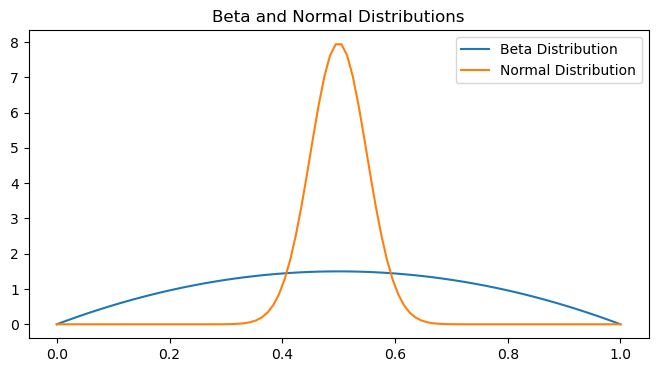

In [7]:
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(points.numpy(), beta_pdf.numpy(), label='Beta Distribution')
plt.plot(points.numpy(), normal_pdf.detach().numpy(), label='Normal Distribution')
plt.title('Beta and Normal Distributions')
plt.legend()
plt.show()

In [8]:
def numerical_integration_KL(q_params, p_params, steps):
    """
    Computes KL(q||p) using trapezoidal rule.
    Inputs
        - q_pdf_values (Tensor): values of pdf of q(x) with increasing x in the valid support.
        - p_pdf_values (Tensor): values of pdf of p(x) with increasing x in the valid support.

    Comments:
        The function assumes the pdfs have overlapping supports.
    """
    concentration_1, concentration_2 = p_params[0], p_params[1]
    mu_q, sigma_q = q_params[0], q_params[1]

    points = torch.linspace(0.000001, 0.99999, steps)
    beta = Beta(concentration_1, concentration_2)
    standard_normal = Normal(loc=0, scale=1)

    beta_pdf = beta.log_prob(points).exp()
    #Sleight of STATS
    normal_pdf = (1/sigma_q)*standard_normal.log_prob((points - mu_q)/sigma_q).exp()
    midpoints = normal_pdf * log(normal_pdf/beta_pdf)
    kl = trapezoid(midpoints, dx=1/steps)
    return kl

In [9]:
num_epochs = 200
q_params = (mu_q, sigma_q)
p_params = (2,2)
#optimizer = Adam(q_params, lr=0.01)
optimizer = SGD(q_params, lr=0.1)
kl_divs = list()
epsilon = 1e-3

for epoch in range(num_epochs):
    optimizer.zero_grad()
    kl_div =  numerical_integration_KL(q_params, p_params, steps)
    kl_div.backward()
    optimizer.step()
    #print(det(sigma_q))
    kl_divs.append(kl_div.item())

    if epoch > 1 and abs(kl_divs[-2] - kl_divs[-1]) < epsilon:
        print("Algorithm converged.")
        print("mu_q is", mu_q)
        print("Sigma_q is", sigma_q)
        break

Algorithm converged.
mu_q is tensor([0.5001], requires_grad=True)
Sigma_q is tensor([1.9820], requires_grad=True)


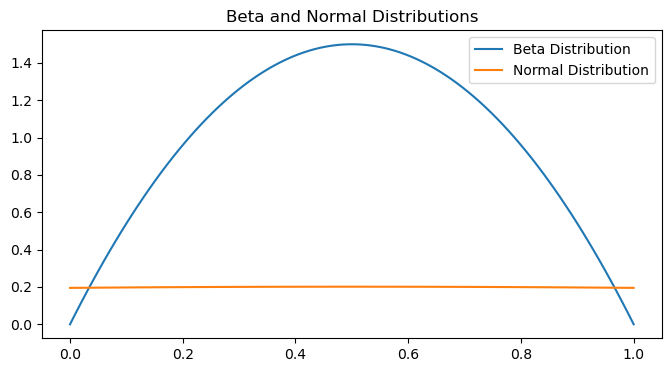

In [10]:
normal_pdf = (1/sigma_q)*standard_normal.log_prob((points - mu_q)/sigma_q).exp()
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(points.numpy(), beta_pdf.numpy(), label='Beta Distribution')
plt.plot(points.numpy(), normal_pdf.detach().numpy(), label='Normal Distribution')
plt.title('Beta and Normal Distributions')
plt.legend()
plt.show()

### What if we only have one sample of iid data? (incomplete)

In this situation, we assume we do not know either distribution, $q$ or $p$, and that we only have a sample of $p$. Additionally, we have a parametrized candidate distribution family $q$, and we want to find the combination of parameters that best approximate $p$ within the family $q$.

In this section, I will use the KL divergence estimator derived [here](https://www.tsc.uc3m.es/~fernando/bare_conf3.pdf), to optimize over the parameters of an approximating distribution. We will summarize the definition and main result here.

We are given $n$ IID samples from $p(x)$, $\chi = \{x_i\}_{i=1}^{n}$, and $m$ IID samples from $q(x)$,  $\chi' = \{x_i'\}_{i=1}^{m}$, assumed sorted in increasing order. The empirical cdf is defined to be:

$$
P_e(x) = \frac{1}{n} \sum_{i=1}^{n} U(x-x_i)
$$

where $U(x)$ is the unit-step function, and $U(0.5)=\frac{1}{2}$. Check [this Wikipedia article](https://en.wikipedia.org/wiki/Heaviside_step_function) for a discussion on the Zero argument of the unit-step function. The continuous piece-wise linear extension to $P_e(x)$ is

$$
P_c(x) = \begin{cases} 
0, & x < x_0 \\
a_ix + b_i, & x_{i-1} \leq x < x_i \\
1, & x_{n+1} \leq x 
\end{cases}
$$

where $a_i$ and $b_i$ are defined such that P_e(x_i) = P_c(x_i) for all $x_i \in \chi$. Without loss of generality, assume $x_{i-1}$ is the $k$-th largest value in the sample, then

$$
P_e(x_{i-1}) = P_c(x_{i-1}) = \frac{k-1}{n} + \frac{1}{2n}, \quad P_e(x_{i}) = P_c(x_{i}) = \frac{k}{n} + \frac{1}{2n}.
$$

From this, it follows that, for $x \in (x_{i-1},x_{i})$:

$$
b_i = \frac{k-1}{n} + \frac{1}{2n}, \quad a_i = \frac{U(x_{i})- U(x_{i-1})}{x_i - x_{i-1}} = \frac{b_{i}- b_{i-1}}{x_i - x_{i-1}}= \frac{1}{n(x_i - x_{i-1})},\quad \text{and} \quad P_c(x) =a_i(x - x_{i-1}) + b_{i-1}
$$

The KL divergence estimator is given by:

$$
\hat{D}(P||Q) = \frac{1}{n} \sum_{i=1}^{n} \log \frac{\delta P_c(x_i)}{\delta Q_c(x_i)}
$$
where $\delta P_c(x_i) = P_c(x_i) - P_c(x_i - \epsilon)$ for any $\epsilon < \min_i\{x_i - x_{i-1}\}$.

**Theorem 1** states: Let $P$ and $Q$ be absolutely continuous probability measures and assume its KL divergence is finite. Let  $\chi = \{x_i\}_{i=1}^{n}$ and $\chi' = \{x_i'\}_{i=1}^{m}$ be i.i.d samples sorted in increasing order, respectively, from $P$ and $Q$, then
$$
\hat{D}(P||Q) - 1 \overset{a.s.}{\to} D(P||Q).
$$

We will state the theorem without proof, as we will concern ourselves with implementing it.

In [11]:
# Original distribution
concentration_1, concentration_2 = 0.5, 0.1  # Beta distribution parameters
beta = Normal(concentration_1, concentration_2)

## IID Samples
n_samples = 1000
sample_p = beta.sample((n_samples,)).squeeze()
sorted_sample_p = sample_p[[sample_p.sort()[1]]]


# Approximating distribution parameters
m_samples = 10
mu_q = torch.tensor([0.5], requires_grad=True)
sigma_q = torch.tensor([0.1], requires_grad=True)
normal = Normal(loc=mu_q, scale=sigma_q)

sample_q = normal.sample((m_samples,)).squeeze()
sorted_sample_q = sample_q[[sample_q.sort()[1]]]

In [12]:
def P_e(data: torch.tensor, plot=False):
    """
    Function outputs the empirical CDF of the data.
    Inputs:
        - data (Tensor): Assumed 1D Tensor containing a SORTED sample.

    Output:
        - empirical CDF Tuple(1D Tensor, 1D Tensor): first coordinate contains steps,
        second coordinate contains the values of the empirical cdf.
    """
    min_obs, max_obs = data.min().item(), data.max().item()
    n = data.size(0)
    xs = torch.linspace(min_obs + 1e-4, max_obs, steps=100)
    Us = xs.unsqueeze(1) > data
    emp_cdf = (1/n) * Us.sum(dim=1) + (1/(2*n))

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(xs.numpy(), emp_cdf.numpy(), label='Empirical CDF')
        #plt.xlim([0, 1])
        plt.title('Empirical CDF')
        plt.legend()
        plt.show()

    return (xs, emp_cdf)
    

In [13]:
def P_c(data, other_dist_data=None, plot=False):
    """
    
    """
    
    min_obs, max_obs = data.min().item(), data.max().item()
    n = data.size(0)
    # Add epislon quantity to min_obs to make sure first x comes after
    if other_dist_data is None:
        xs = torch.linspace(min_obs + 1e-4 , max_obs, steps=100)
    else:
        xs = other_dist_data
    Us = xs.unsqueeze(1) > data
    # Given x, what is the order of x_i < x such that x < x_{i+1} 
    x_i_order = Us.sum(dim=1)
    x_i_order = torch.max(x_i_order, torch.zeros_like(x_i_order))
    x_i_order = torch.min(x_i_order, (n - 1)*torch.ones_like(x_i_order))

    # To find x_i in the sorted array, then it suffices to index by the ordering obtained minus one
    diffs = data[x_i_order] - data[x_i_order -1]
    #diffs =  torch.max(diffs, torch.zeros_like(diffs))
    a_i = 1/(n*diffs) 
    b_i = (x_i_order )/n + (1/(2*n))
    emp_dist_c = a_i * (xs - data[x_i_order - 1]) + b_i
    emp_dist_c = torch.min(emp_dist_c, torch.ones_like(x_i_order))
    emp_dist_c = torch.max(emp_dist_c, torch.zeros_like(x_i_order))


    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(xs.numpy(), emp_dist_c.numpy(), label='Empirical CDF')
        plt.title('Empirical CDF')
        #plt.xlim([0, 1])
        plt.legend()
        plt.show()


    return (b_i, a_i, xs, emp_dist_c)


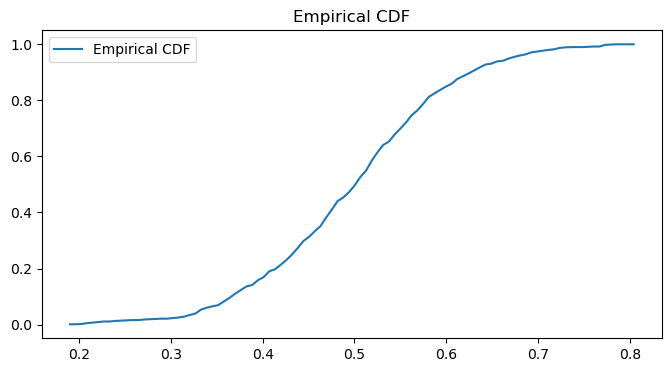

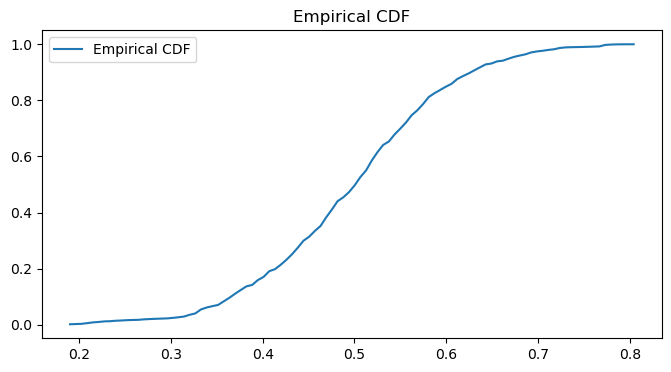

In [14]:
xs, emp_cdf = P_e(sorted_sample_p, plot=True)
bi_p,ai_p,xi_p,emp_p = P_c(sorted_sample_p, plot=True)

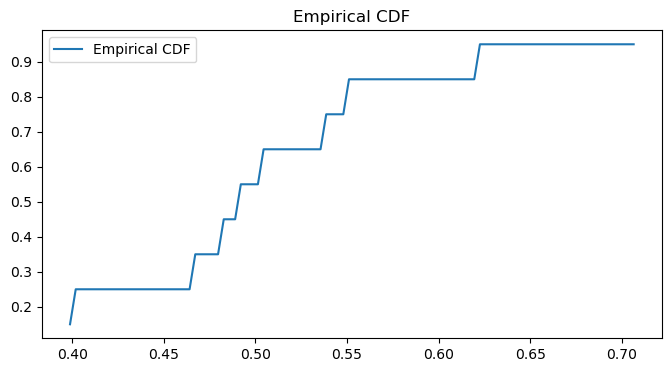

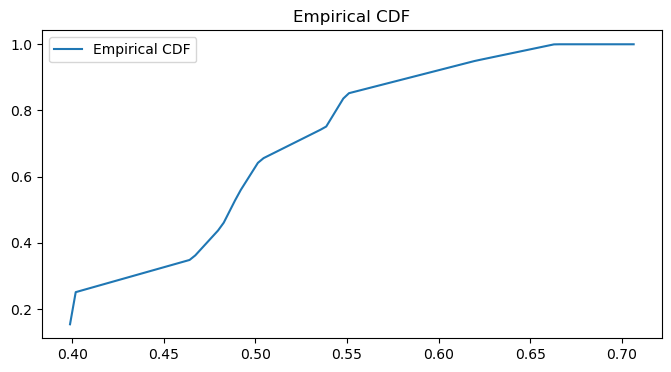

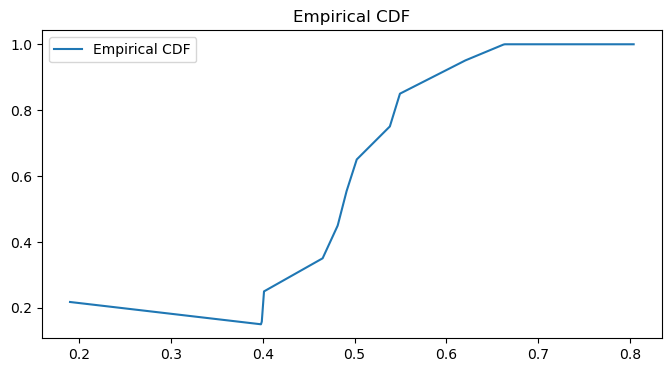

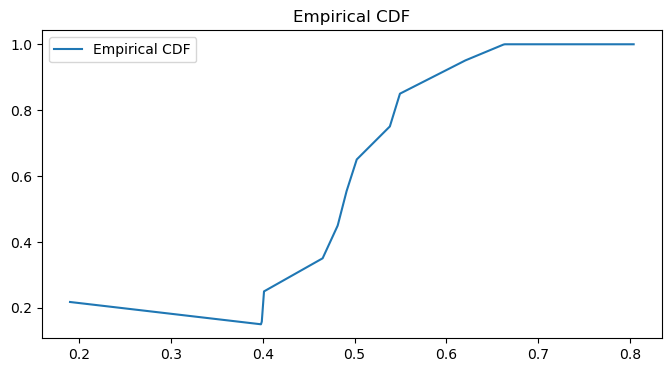

In [15]:
epsilon = torch.diff(sorted_sample_p).min()/2
xs, emp_cdf = P_e(sorted_sample_q, plot=True)
bi_q,ai_q,xi_q,emp_q = P_c(sorted_sample_q, plot=True)
bi_qp,ai_qp,xi_qp,emp_qp = P_c(sorted_sample_q,other_dist_data=sorted_sample_p, plot=True)
bi_qp_eps,ai_qp_eps,xi_qp_eps,emp_qp_eps = P_c(sorted_sample_q, other_dist_data=sorted_sample_p - epsilon, plot=True)

In [16]:
print(emp_cdf)

tensor([0.1500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.3500, 0.3500, 0.3500, 0.3500, 0.3500,
        0.4500, 0.4500, 0.4500, 0.5500, 0.5500, 0.5500, 0.5500, 0.6500, 0.6500,
        0.6500, 0.6500, 0.6500, 0.6500, 0.6500, 0.6500, 0.6500, 0.6500, 0.6500,
        0.7500, 0.7500, 0.7500, 0.7500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500,
        0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500,
        0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500,
        0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500,
        0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500,
        0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500,
        0.9500])


In [17]:
print(emp_q)

tensor([0.1539, 0.2510, 0.2558, 0.2607, 0.2656, 0.2704, 0.2753, 0.2801, 0.2850,
        0.2899, 0.2947, 0.2996, 0.3045, 0.3093, 0.3142, 0.3191, 0.3239, 0.3288,
        0.3337, 0.3385, 0.3434, 0.3482, 0.3620, 0.3808, 0.3996, 0.4185, 0.4373,
        0.4609, 0.4948, 0.5287, 0.5601, 0.5873, 0.6145, 0.6417, 0.6560, 0.6646,
        0.6731, 0.6817, 0.6903, 0.6989, 0.7075, 0.7161, 0.7247, 0.7333, 0.7419,
        0.7515, 0.7797, 0.8078, 0.8360, 0.8522, 0.8566, 0.8610, 0.8655, 0.8699,
        0.8743, 0.8787, 0.8831, 0.8875, 0.8919, 0.8963, 0.9007, 0.9051, 0.9095,
        0.9139, 0.9183, 0.9228, 0.9272, 0.9316, 0.9360, 0.9404, 0.9448, 0.9492,
        0.9529, 0.9565, 0.9601, 0.9637, 0.9673, 0.9709, 0.9745, 0.9781, 0.9817,
        0.9853, 0.9889, 0.9925, 0.9961, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [18]:
def estimated_KL(sorted_sample_p, sorted_sample_q):

    epsilon = torch.diff(sorted_sample_p).min()/2
    n = sorted_sample_p.size(0)
    
    bi_p,ai_p,xi_p,emp_p = P_c(sorted_sample_p)
    bi_p_eps,ai_p_eps,xi_p_eps,emp_p_eps = P_c(sorted_sample_p, other_dist_data=sorted_sample_p - epsilon)
    bi_qp,ai_qp,xi_qp,emp_qp = P_c(sorted_sample_q, other_dist_data=sorted_sample_p)
    bi_qp_eps,ai_qp_eps,xi_qp_eps,emp_qp_eps = P_c(sorted_sample_q, other_dist_data=sorted_sample_p - epsilon)

    D_hat = (1/n)*log((emp_p - emp_p_eps)/(emp_qp - emp_qp_eps)).sum()
    #print(emp_p - emp_p_eps)
    print(log((emp_p - emp_p_eps)/(emp_qp - emp_qp_eps)))

    return D_hat


## Footnotes

<span id="fn1">1</span>: Despite $\ln \frac{p(x)}{q(x)}$ being undefined for $p(x)=0$, applying L'Hopital's rule verifies that $\lim_{p(x)\to 0}p(x) \ln \frac{p(x)}{q(x)} = 0$, for $q(x)>0$. The function is well-behaved around $p(x)=0$.


## Cool stuff

- [KL Divergence Estimation of Continuos Distributions](https://www.tsc.uc3m.es/~fernando/bare_conf3.pdf)


In [19]:
estimated_KL(sorted_sample_p, sorted_sample_q)

RuntimeError: The size of tensor a (100) must match the size of tensor b (1000) at non-singleton dimension 0